Cell 1: Area=12414.5, Diameter=125.72, Radius=62.86, Circularity=9.87, Centroid=(679.0, 298.0), Contrast=44.95, Correlation=0.98, Energy=0.04, Homogeneity=0.25
Cell 2: Area=6193.5, Diameter=88.80, Radius=44.40, Circularity=9.87, Centroid=(215.0, 627.0), Contrast=48.97, Correlation=0.99, Energy=0.05, Homogeneity=0.26


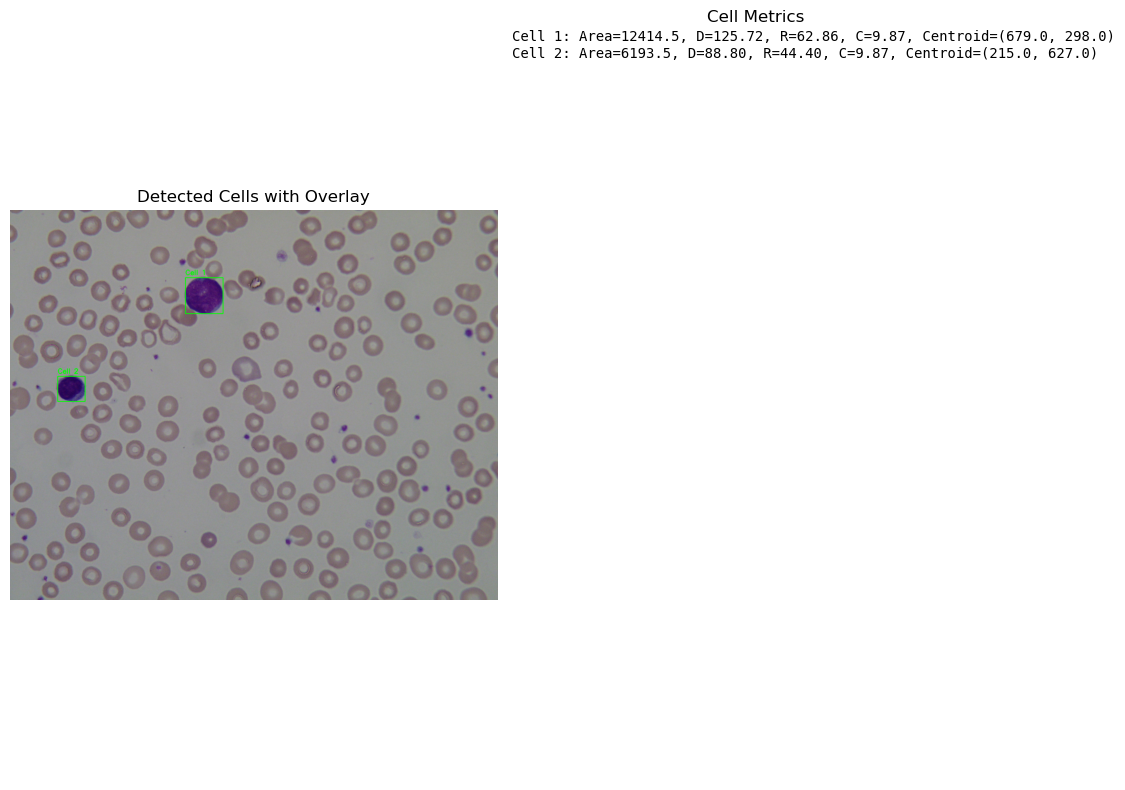

In [1]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

def extract_glcm_features(region_image):
    # Convert region image to grayscale
    gray_image = cv2.cvtColor(region_image, cv2.COLOR_BGR2GRAY)
    
    # Compute GLCM (grey-level co-occurrence matrix)
    glcm = graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    
    # Compute features: contrast, correlation, energy, homogeneity
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return contrast, correlation, energy, homogeneity

def analyze_and_display_cells_with_advanced_watershed(image_path):
    # Read image
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    s_channel = cv2.split(hsv_image)[1]
    adjusted_s = 2 * (s_channel / 255.0)
    segmented_mask = np.where(adjusted_s > 0.7, 1, 0).astype(np.uint8)

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned_mask = cv2.morphologyEx(segmented_mask, cv2.MORPH_OPEN, kernel)

    # Distance transform to separate touching cells
    dist_transform = cv2.distanceTransform(cleaned_mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(cleaned_mask, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 1] = 0

    # Apply watershed
    output_image = image.copy()
    markers = cv2.watershed(output_image, markers)

    # Advanced contour analysis and splitting
    cell_metrics = []
    for label in np.unique(markers):
        if label == -1 or label == 1:  # Skip background and watershed boundary
            continue

        # Create a mask for the current label
        mask = np.zeros_like(cleaned_mask, dtype=np.uint8)
        mask[markers == label] = 255

        # Compute contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            area = cv2.contourArea(c)
            if area < 950:  # Skip small regions
                continue

            # Analyze bounding box
            x, y, w, h = cv2.boundingRect(c)
            diameter = np.sqrt(4 * area / np.pi)
            M = cv2.moments(c)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            radius = diameter / 2
            circularity = 4 * np.pi * area / (diameter**2)
            cell_metrics.append((len(cell_metrics) + 1, area, diameter, radius, circularity, (cx, cy)))

            # Extract GLCM features for this specific cell region
            cell_region = image[y:y + h, x:x + w]
            contrast, correlation, energy, homogeneity = extract_glcm_features(cell_region)

            # Draw bounding box and label
            color = (0, 255, 0)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(output_image, f"Cell {len(cell_metrics)}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            # Display GLCM features in metrics
            print(f"Cell {len(cell_metrics)}: Area={area}, Diameter={diameter:.2f}, Radius={radius:.2f}, Circularity={circularity:.2f}, "
                  f"Centroid=({cx:.1f}, {cy:.1f}), Contrast={contrast:.2f}, Correlation={correlation:.2f}, Energy={energy:.2f}, Homogeneity={homogeneity:.2f}")

    # Convert output image to RGB for Matplotlib
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Plot the overlayed image and metrics
    plt.figure(figsize=(12, 8))

    # Overlayed Image
    plt.subplot(1, 2, 1)
    plt.imshow(output_image_rgb)
    plt.title("Detected Cells with Overlay")
    plt.axis("off")

    # Display Metrics
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Cell Metrics")
    
    # Create a text display for metrics
    metrics_text = "\n".join(
        [f"Cell {cell_id}: Area={area}, D={diameter:.2f}, R={radius:.2f}, C={circularity:.2f}, Centroid=({cx:.1f}, {cy:.1f})"
         for cell_id, area, diameter, radius, circularity, (cx, cy) in cell_metrics]
    )
    plt.text(0, 1, metrics_text, fontsize=10, va="top", family="monospace")

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    analyze_and_display_cells_with_advanced_watershed("E:/IMPART_DX/ALL_Work/ALLSET/Im031_1.jpg")
